# Fisher Vector Encoding Basics

GMM with $K$ components and diagonal covariance matrix:
$$
\begin{equation}
    p(\vec{x}_n|\Theta) = \sum_{k=1}^{K} \alpha_k p_k(\vec{x}_n|\theta_k) \\
	p_k(\vec{x}_n|\vec{\mu}_k, \vec{\sigma}_k)
	= \dfrac{1}{\prod_{d=1}^{D}\sqrt{2\pi} \sigma_{k,d}}
    \exp\left(-\sum_{d=1}^{D}\frac{(x_{n,d} - \mu_{k,d})^2}{2 (\sigma_{k,d})^2}\right)\quad.
\end{equation}
$$

FVE based on this GMM:

$$
\begin{align}
	\mathcal{F}_{\mu_{k,d}}(\mathcal{X}_I)
		&= \dfrac{1}{\sqrt{N_I\alpha_k}}\sum_{n=1}^{N_I} w_{n,k} \left(\dfrac{x_{n,d} - \mu_{k,d}}{\sigma_{k,d}}\right)\quad,
		\\
	\mathcal{F}_{\sigma_{k,d}}(\mathcal{X}_I)
		&= \dfrac{1}{\sqrt{2N_I\alpha_k}}\sum_{n=1}^{N_I} w_{n,k} \left(\dfrac{(x_{n,d} - \mu_{k,d})^2}{(\sigma_{k,d})^2} - 1\right)\quad,
\end{align}
$$ 

with soft assignment

$$
\begin{equation}
	w_{n,k} = \dfrac{\alpha_k p_k(\vec{x}_n|\theta_k)}{\sum_{\ell=1}^{K}\alpha_\ell p_\ell(\vec{x}_n|\theta_\ell)}\quad.
	\label{eq:soft_assignment}
\end{equation}
$$

The gradients of this encoding w.r.t. an input feature $x_{n,d_*}$ are:

$$
\begin{align}
	\frac{\partial\mathcal{F}_{\mu_{k,d}}(\mathcal{X}_I)}{\partial{x_{n,d_*}}}
		&= \dfrac{1}{\sqrt{N_I\alpha_k}}\left[\frac{\partial{w_{n,k}}}{\partial{x_{n,d_*}}}\left(\dfrac{x_{n,d} - \mu_{k,d}}{\sigma_{k,d}}\right) + \delta_{d,d_*}\frac{w_{n,k}}{\sigma_{k,d_*}}\right] \quad,\\
	\frac{\partial\mathcal{F}_{\sigma_{k,d}}(\mathcal{X}_I)}{\partial{x_{n,d_*}}}
		&= \dfrac{1}{\sqrt{2N_I\alpha_k}}\left[
		     \frac{\partial{w_{n,k}}}{\partial{x_{n,d_*}}}\left(\dfrac{(x_{n,d} - \mu_{k,d})^2}{(\sigma_{k,d})^2} - 1\right)\right. \nonumber \\
		     & \phantom{==\dfrac{1}{\sqrt{2N_I\alpha_k}}}\left.+\delta_{d,d_*}\frac{2 w_{n,k}(x_{n,d_*}-\mu_{k,d_*})}{(\sigma_{k,d_*})^2}\right]\quad.
\end{align}
$$
In both equations, we use $\delta_{d,d_*}$ to denote the Kronecker delta being $1$ if $d=d_*$ and $0$ else, as well as the derivative of $w_{n,k}$ w.r.t. $x_{n,d_*}$ that is given by:
$$
\begin{equation}
    \frac{\partial{w_{n,k}}}{\partial{x_{n,d_*}}} = w_{n,k}\left(-\frac{(x_{n,d_*}-\mu_{k,d_*})}{(\sigma_{k,d_*})^2} + \sum_{\ell=1}^K w_{n,\ell}\frac{(x_{n,d_*}-\mu_{\ell,d_*})}{(\sigma_{\ell,d_*})^2} \right)\quad.
\end{equation}
$$

In [197]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
import numpy as np
import chainer
import cv2
import abc
import sys
import pyaml

from chainer import functions as F
from chainer import links as L

from ipywidgets import interactive
from tabulate import tabulate

from matplotlib import pyplot as plt
from dataclasses import dataclass
from typing import Tuple

from fve_layer.backends.chainer import links
from fve_layer.common.visualization import draw_ellipse

print(f"Chainer version: {chainer.__version__}")

chainer.config.train = False

Chainer version: 7.7.0


# Arguments

In [440]:
@dataclass
class Args:
    n_components:       int     = 3
    n_dims:             int     = 2
        
    init_mu:            float   = 10 # ~ U(-init_mu, init_mu)
    rnd_mu:             bool    = True
    init_sig:           float   = 1.5
    eps:                float   = 1e-2
        
    x_range:            Tuple[float, float] = (-10, 10)
    y_range:            Tuple[float, float] = (-10, 10)
    n_samples:          int     = 25
        
    
    seed:               int     = 42
        
    def __str__(self):
        return pyaml.dump(self.__dict__, sort_dicts=False)


# Data and Layer initializers

In [441]:
def new_layer(args: Args, mu=None, sig=None, N=None):
    
    init_mu = args.init_mu if mu is None else mu
    n_comp = args.n_components if N is None else N
    
    # the random mu initialization (uniform in [-init_mu, init_mu]) is realized by the layer
    if not args.rnd_mu:
        init_mu = np.full((args.n_dims, n_comp), init_mu, dtype=np.float32)
        

    layer = links.FVELayer_noEM(
        in_size=args.n_dims,
        n_components=n_comp,

        init_mu=init_mu,
        init_sig=args.init_sig if sig is None else sig,

        eps=args.eps
    )
    layer.cleargrads()

    return layer

In [442]:
def new_data_grid(args: Args):
    
    xs,ys = [np.linspace(*r, num=args.n_samples) for r in [args.x_range, args.y_range]]
    grid = np.stack(np.meshgrid(ys, xs), axis=2).astype(np.float32)
    return grid

In [443]:
def new_data(args: Args, n_samples: int = 200, return_labels: bool = False):
    X, y, *_ = generate_data(args.n_components, n_samples)

    _rows = int(np.ceil(np.sqrt(X.shape[0])))
    _cols = int(np.ceil(X.shape[0] / _rows))
    
    shape = (_cols, _rows, 2)
    result = np.zeros(shape, dtype=X.dtype)
    result[np.unravel_index(np.arange(X.shape[0]), shape[:-1])] = np.squeeze(X)
    
    if return_labels:
        return result, y
    
    return result

def generate_data(n_classes, n_samples, *, rnd=None, overlap=False, map_size=1, dtype=np.float32):
    Xs, ys = [], []
    
    if rnd is None:
        rnd = np.random.RandomState()

    _comp_pos = np.linspace(0, 2*np.pi, n_classes, endpoint=False)
    _means = np.vstack([np.cos(_comp_pos), np.sin(_comp_pos)]).T
    _std_factor = 2 if overlap else 1
    _std = np.array([1., 1.]) / n_classes * _std_factor

    for i, mean in enumerate(_means):
        X = rnd.normal(loc=mean, scale=_std, size=(n_samples, 2))
        X = X.astype(dtype)

        X = np.expand_dims(np.expand_dims(X, 1), 1)
        _pad_size = (map_size - 1) // 2
        pad = (_pad_size, _pad_size)
        X = np.pad(X, pad_width=[(0,0), pad, pad, (0,0)], mode="constant")

        noise = rnd.normal(loc=(0, 0), scale=(0.01, 0.01), size=X.shape)
        noise_mask = X==0
        X[noise_mask] = noise[noise_mask]

        X = X.reshape(n_samples, -1, 2)

        y = np.full(shape=n_samples, fill_value=i, dtype=dtype)
        y = np.expand_dims(y, 1)
        y = np.broadcast_to(y, (n_samples, X.shape[1]))

        Xs.append(X)
        ys.append(y)

    Xs = np.vstack(Xs)
    ys = np.vstack(ys)

    return Xs*10, ys, _means*10, _std*10

# Plotting helper

In [444]:
def _norm(arr, axis=(0,1)):
    _min = arr.min(axis=axis)
    arr[:] -= _min
    _max = arr.max(axis=axis, keepdims=True)
    _max_mask = _max != 0
    if _max_mask.any():
        arr_mask = np.broadcast_to(_max_mask, arr.shape)
        arr[arr_mask] /= np.broadcast_to(_max, arr.shape)[arr_mask]
    
    return _min, np.squeeze(_max)

def _denorm(arr, _min, _max):
    _max_mask = _max != 0
    if _max_mask.any():
        arr = arr.copy()
        arr[_max_mask] *= _max[_max_mask] 

    return arr + _min

def _toarray(var, attr="array"):
    return getattr(var, attr, var)

def _scatter(ax: plt.Axes, values: np.ndarray, x_range, y_range, *, 
             labels=None, encoding=None, title=None, **kwargs):
    assert values.shape[-1] == 2
    values = _toarray(values)
    
    _values = values.reshape(-1, 2)
    _values = _values.T
    
    c = None
    if labels is not None:
        assert encoding is None, "Either labels or encoding are allowed!"
        c = labels
    elif encoding is not None:
        assert labels is None, "Either labels or encoding are allowed!"
        
        c = np.zeros(encoding.shape[:-1] + (3,), dtype=encoding.dtype)
        c[..., 1:] = _toarray(encoding)
        _norm(c)
        c = c.reshape(-1, 3)
    else:
        c = None
    ax.scatter(*_values, c=c, **kwargs)
    
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    
    
def _imshow(ax: plt.Axes, im: np.ndarray, x_range, y_range, *, 
            title=None, YUV2RGB=False, display_values=5, ndecimals=4,
            **kwargs
           ):
    assert im.shape[-1] == 2
    im = _toarray(im)
    
    _im = np.zeros(im.shape[:-1] + (3,), dtype=im.dtype)
    _im[..., 1:] = im.copy()
    
    _min, _max = _norm(_im)
    
    if YUV2RGB:
        _im = cv2.cvtColor(_im, cv2.COLOR_YUV2RGB)

    _norm(_im)
    _im[..., 0] = 0

    ax.imshow(_im.round(ndecimals), extent=x_range + y_range, origin="lower")
    
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    
    if display_values < 1:
        return
    h, w, _ = _im.shape
    xs = np.linspace(*x_range, display_values)
    ys = np.linspace(*y_range, display_values)
    _js = np.linspace(0, w-1, display_values).astype(int)
    _is = np.linspace(0, h-1, display_values).astype(int)

    fmt = "\n".join(["{x} | {y}", "R={0: .2f}", "G={1: .2f}", "B={2: .2f}"])
    for y, i in zip(ys, _is):
        for x, j in zip(xs, _js):

            text = fmt.format(*_denorm(_im[i, j], _min, _max), x=x, y=y)
            if i == _is.min():
                verticalalignment = "bottom"
            elif i == _is.max():
                verticalalignment = "top"
            else:
                verticalalignment = "center"

            if j == _js.min():
                horizontalalignment = "left"
            elif j == _js.max():
                horizontalalignment = "right"
            else:
                horizontalalignment = "center"

            ax.text(x,y, s=text, 
                    bbox=dict(facecolor="white", alpha=0.5),
                    horizontalalignment=horizontalalignment,
                    verticalalignment=verticalalignment,
                   )
            ax.scatter(x, y, marker="x", color="white")
                


n_components: 3
n_dims: 2
init_mu: 10
rnd_mu: true
init_sig: 1.5
eps: 0.01
x_range: &y_range
  - -10
  - 10
y_range: *y_range
n_samples: 25
seed: 42

(24, 25, 2)


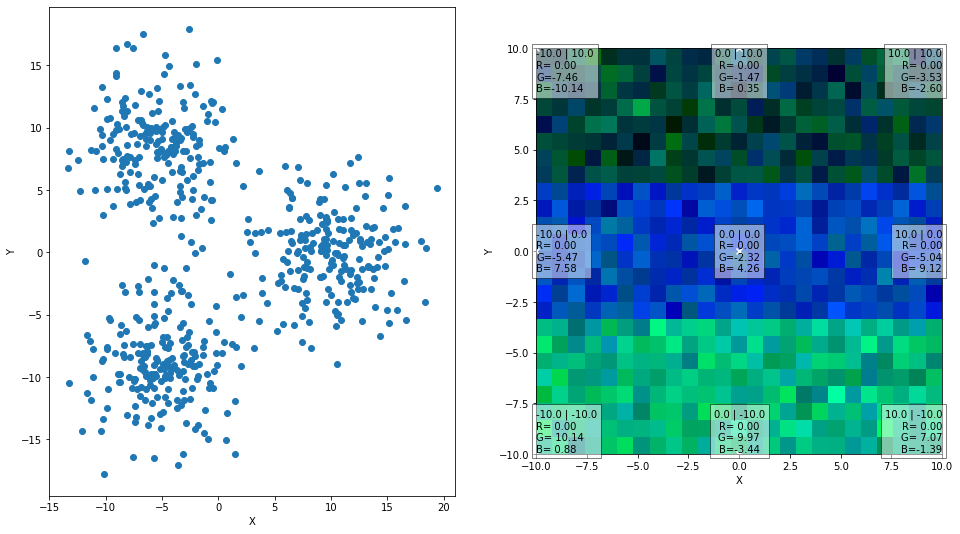

In [445]:
args = Args(n_components=3)
print(args)

X = new_data(args)

print(X.shape)
fig, axs = plt.subplots(1,2, figsize=(16,9))
ranges = args.x_range, args.y_range
_scatter(axs[0], X, *ranges)
_imshow(axs[1], X, *ranges, display_values=3)

# Printing helper


## Gradient printing

We compute the actual $\vec{\sigma^2}$ and $\vec{w}$ indirectly from learned network parameters $\vec{s}$ and $\vec{v}$:

$$
\begin{align}
    \sigma^2_i 
        &= \epsilon + \exp(s_i), \quad s \in \mathbb{R} \\
    w_i 
        &= \dfrac{\mathrm{sigmoid}(v_i)}{\sum_{j} \mathrm{sigmoid}(v_j)}, \quad v_i \in \mathbb{R} \\        
\end{align}
$$

In the network, we can only observe the gradients w.r.t. the learned parameters:

$$
\begin{align}
\dfrac{\partial \mathcal{F}_\Theta(X)}{\partial \vec{s}}
    &= \dfrac{\partial \mathcal{F}_\Theta(X)}{\partial \vec{\sigma^2}} \cdot 
    \dfrac{\partial \vec{\sigma^2}}{\partial \vec{s}}\\
\dfrac{\partial \mathcal{F}_\Theta(X)}{\partial \vec{v}}
    &= \dfrac{\partial \mathcal{F}_\Theta(X)}{\partial \vec{w}} \cdot 
    \dfrac{\partial \vec{w}}{\partial \vec{v}}\\
\end{align}
$$

Hence, the actual gradients of the encoding w.r.t. the GMM paramters are 
(some indexing is missing, but it should be straighforward to complement those):


$$
\begin{align}
\dfrac{\partial \mathcal{F}_\Theta(X)}{\partial \vec{\sigma^2}}
    &= \dfrac{\partial \mathcal{F}_\Theta(X)}{\partial \vec{s}} \cdot
        \left(\dfrac{\partial \vec{\sigma^2}}{\partial \vec{s}}\right)^{-1} \\
    &= \dfrac{\partial \mathcal{F}_\Theta(X)}{\partial \vec{s}} \cdot
         \dfrac{1}{\exp(\vec{s})} \\
\dfrac{\partial \mathcal{F}_\Theta(X)}{\partial \vec{w}}
    &= \dfrac{\partial \mathcal{F}_\Theta(X)}{\partial \vec{v}}
        \left(\dfrac{\partial \vec{w}}{\partial \vec{v}}\right)^{-1} \\
    &= \dfrac{\partial \mathcal{F}_\Theta(X)}{\partial \vec{v}} \circ
    \left(\vec{w}\circ\vec{1}^T \circ \left(\left(\mathbf{1} - \vec{1}\circ\vec{w}^T\right) \cdot \left(\vec{1}-\mathrm{sigmoid}(\vec{v}^T)\right)\right)\right)^{-1}
\end{align}
$$

Following code cofirms the computations

In [485]:
shape = (2,3)
data = np.random.randn(*shape)
_sig = chainer.Variable(data, requires_grad=True)
eps = 1e-2
sig = eps + F.exp(_sig)

sig.grad = np.full(sig.shape, fill_value=125, dtype=sig.dtype)
_sig.grad = None

with chainer.force_backprop_mode():
    sig.backward(retain_grad=True)

print("==" * 5, "_sig Grad:", "==" * 5)
print("Direct:\n", _sig.grad)
print("Indirect:\n",  (sig.array - eps) * sig.grad)

print("==" * 5, "sig Grad:", "==" * 5)
print("Direct:\n", sig.grad)
print("Indirect:\n", _sig.grad / (sig.array - eps))

========== _sig Grad: ==========
Direct:
 [[ 56.55884925 172.60665399 383.1336351 ]
 [147.93185208  16.17105329  23.74793374]]
Indirect:
 [[ 56.55884925 172.60665399 383.1336351 ]
 [147.93185208  16.17105329  23.74793374]]
========== sig Grad: ==========
Direct:
 [[125. 125. 125.]
 [125. 125. 125.]]
Indirect:
 [[125. 125. 125.]
 [125. 125. 125.]]


In [446]:
def _print(params, data_name="array", headers=["\u03BC", "\u03C3", "w"]):
    
    rows = []
    _get = lambda param: getattr(param, data_name, param)
    p_arrays = [_get(p) for p in params]
    for i, params in enumerate(zip(*p_arrays), 1):
        rows.append([f"Comp #{i}"] + [p.round(6) for p in params])
    print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))

def print_arrays(layer):
    _print([layer.mu.T, layer.sig.T, layer.w], "array")
    
    

In [476]:
def sig_grad(layer):
    return layer._sig.grad / (layer.sig.array - layer.eps)

def w_grad(layer):
    
    """ Source: http://saitcelebi.com/tut/output/part2.html#back_propagation_phase"""
    w, _w = layer.w.array, layer._w.array
    assert w.ndim == 1
    n, = w.shape
    
    y0 = np.matmul(w.reshape(-1, 1), np.ones((1, n)))
    y1 = np.identity(n) - np.matmul(np.ones((n, 1)), w.reshape(1, -1))
    y2 = (1 - F.sigmoid(_w).array).reshape(-1, 1)
    grad_matrix = y0 * y1 * y2
    inv_grad_matrix = np.linalg.pinv(grad_matrix)
    
    return inv_grad_matrix @ layer._w.grad

def get_w_grad(layer):
    for p in layer._ws:
        if p.grad is not None:
            return p.grad

def print_grad(layer, enc_part):
    params = [
        layer.mu.grad.T, 
        layer._sig.grad.T,
        sig_grad(layer).T,
        # layer._w, 
        # w_grad(layer), 
        get_w_grad(layer),
    ]
    param_names = [
        "\u03BC", 
        "_\u03C3", 
        "\u03C3", 
        # "_w", 
        # "w*", 
        "w",
    ]
    _print(params, "grad", 
           headers=[f"\u2202 F{enc_part} / \u2202 {name}" for name in param_names])
    

# Base Plotter class

In [477]:

class Plotter(abc.ABC):
    __name__ = "Plotter"
    
    def __init__(self, X, args, *, max_comps=10, **kwargs):
        self.args = args
        self.X = X
        self.max_comps = max_comps

        
    def __call__(self=None, 
                 mu=Args.init_mu, 
                 sig=Args.init_sig, 
                 N=Args.n_components):
        
        _mu = mu = np.random.uniform(low=-mu, high=mu, size=(args.n_dims, N))
        _mu[:, 0] = -args.init_mu * 1.5
        if N>=2:
            _mu[:, 1] = 0            
        layer = new_layer(self.args, _mu, sig, N)
        
        print_arrays(layer)
        self.plot(layer, self.X)
        
        #plt.tight_layout()
        plt.show()
        plt.close()
    
    def encode(self, layer, X):
        h, w, c = X.shape
        X = chainer.Variable(X)
        
        enc = layer(X.reshape(h*w, 1, c))
        enc = enc.reshape(h*w, 2, layer.n_components, layer.in_size)
        
        if layer.n_components > self.max_comps:
            print("More than {0} components! Plotting only the first {0}!".format(self.max_comps), 
                  file=sys.stderr)
            enc = enc[:, :, :self.max_comps]
        
        mu_enc, sig_enc = enc[:, 0], enc[:, 1]
        
        return X, mu_enc, sig_enc
        
    
    def interact(self, height=None,
                 mu=(-10, 10, 0.1), 
                 sig=(0.1, 15, 0.1),
                 N=(1, 32, 1)):
        _plot = interactive(self, mu=mu, sig=sig, N=N)
        
        # set fixed size if flickering is annoying
        if height is not None:
            output = _plot.children[-1]
            output.layout.height = f"{height}px"
        
        return _plot
        
    def plot(self, layer, X):
        fig, axs = plt.subplots(1,2, figsize=(16,8))
        fig.suptitle("Data and the GMM")
        
        ranges = self.args.x_range, self.args.y_range
        _imshow(axs[0], X, *ranges, title="Data")
        _scatter(axs[1], X, *ranges, title="Data", alpha=0.5)
        
        layer.plot(ax=axs[0])
        layer.plot(ax=axs[1])
        
#         axs[1].set_xlim(*self.args.x_range)
#         axs[1].set_ylim(*self.args.y_range)
        
        self.plot_core(layer, X)
        
    @abc.abstractmethod
    def plot_core(self, layer, X):
        pass

In [478]:
class EncodingPlotter(Plotter):
    
    def plot_core(self, layer, X):
        n0, n1, c = X.shape
        X, mu_enc, sig_enc = self.encode(layer, X)
            
        n_comp = mu_enc.shape[1]
        
        for i in np.arange(n_comp):
            
            fig, axs = plt.subplots(1, 2, figsize=(16,8))
            fig.suptitle(f"Component #{i}")
            fmt = "$\mathcal{{F}}_{{{param}_{{" + str(i) + "}}}}(x)$"
            for j, (_x, param) in enumerate(zip([mu_enc, sig_enc], ["\mu", "\sigma^2"])):
                title = fmt.format(param=param)
                _im = _x[:, i].reshape(n0, n1, 2)
                ranges = self.args.x_range, self.args.y_range
#                 if self._data_factory == new_data:
                _scatter(axs[j], X, *ranges, encoding=_im, title=title)
                layer.plot(axs[j])
#                 else:
#                     _imshow(axs[j], _im, *ranges, title=title)

In [479]:
args = Args(
    eps=0,
)
plotter = EncodingPlotter(
    args=args,
    X=new_data(args)
)

plotter.interact()

interactive(children=(FloatSlider(value=10.0, description='mu', max=10.0, min=-10.0), FloatSlider(value=1.5, d…

In [488]:
from sklearn.svm import LinearSVC

class GradPlotter(Plotter):
    def __init__(self, y, *args, **kwargs):
        super(GradPlotter, self).__init__(*args, **kwargs)
        self.y = y.squeeze().astype(int)
        self._lin = None
    
    @property
    def lin(self):
        if self._lin is None:
            self._lin = L.Linear(len(np.unique(self.y)))
        
        return self._lin
        
    def predict(self, X):
        return F.mean(X)
        y = self.y
        X = X.reshape(len(y), -1)
        
        classes = np.unique(y)
        n, feat_size = X.shape
        
        if self._lin is not None and self._lin.W is not None:
            if self._lin.W.shape[1] != feat_size:
                # re-init the layer if the encoding size changed
                print("re-initializing FC layer")
                self._lin = None
        
        svm = LinearSVC()
        _X, _y = _toarray(X), _toarray(y)
        svm.fit(_X + np.random.randn(*_X.shape)*_X.std()*.5, _y)
        
        initW = np.vstack([-svm.coef_, svm.coef_])
        initb = np.hstack([-svm.intercept_, svm.intercept_])

        lin = L.Linear(feat_size, len(classes), initialW=initW, initial_bias=initb)
        
        pred = lin(X)
        
        print(svm.score(_X, _y), (pred.array.argmax(axis=1) == _y).mean())
        return F.softmax_cross_entropy(pred, y)
        
    
    def plot_core(self, layer, X):
        
       
        n0,n1,c = X.shape
        n0, n1, c = X.shape
        X, mu_enc, sig_enc = self.encode(layer, X)
        enc_names = ["\mu", "\sigma^2"]
        
        title_fmt = "$\dfrac{{\partial}}{{\partial x}}\mathcal{{F}}_{{{param}}}(x)$" 
        
        encs = [F.sum(mu_enc, axis=1), F.sum(sig_enc, axis=1)]
        
        _title = f"All components"
        print(f"=== {_title} ===")
        fig, axs = self.plot_grad(layer, X, encs, enc_names, 
                                  no_grad_print=False,
                                  title_fmt=title_fmt)
        
        fig.suptitle(_title)
        
        
        for i in np.arange(mu_enc.shape[1]):
            
            title_fmt = "$\dfrac{{\partial}}{{\partial x}}\mathcal{{F}}_{{{param}_{{" + str(i) + "}}}}(x)$" 

            encs = [mu_enc[:, i], sig_enc[:, i]]
            
            _title = f"Component #{i}"
            print(f"=== {_title} ===")
            fig, axs = self.plot_grad(layer, X, encs, enc_names, 
                                      no_grad_print=False,
                                      title_fmt=title_fmt)

            _title = f"Component #{i}"
            fig.suptitle(_title)
        
    def plot_grad(self, layer, X, encs, enc_names, *, no_grad_print, title_fmt):
        
        fig, axs = plt.subplots(1, len(encs), figsize=(8*len(encs), 8))
        
        for ax, _enc, enc_name in zip(axs, encs, enc_names):
            X.grad = None
            layer.cleargrads()
            loss = self.predict(_enc)
            loss.backward(retain_grad=True)
            
            title = title_fmt.format(param=enc_name)
            if "mu" in enc_name:
                enc_part = "\u03BC"
                
            elif "sig" in enc_name:
                enc_part = "\u03C3"
                
            else:
                enc_part = "\u03B8"
            
            ranges = self.args.x_range, self.args.y_range
            
            #_scatter(ax, X, *ranges, encoding=X.grad, title=title, alpha=.5)
            assignment = layer.soft_assignment(X).array.argmax(axis=-1)
            _scatter(ax, X, *ranges, labels=assignment.reshape(-1), title=title, alpha=.5)
            layer.plot(ax)
            
            for (x0, y0), (dx, dy) in zip(layer.mu.array.T, -layer.mu.grad.T):
                ax.arrow(x0, y0, dx, dy, width=2.5e-1)
            
#             for mu, (sx, sy), (dsx, dsy) in zip(layer.mu.array.T, layer.sig.array.T, sig_grad(layer).T):
#                 new_sig = np.array([sx-dsx, sy-dsy], dtype=mu.dtype)
#                 new_sig = np.maximum(new_sig, layer.eps)
#                 draw_ellipse(mu, new_sig, nsig=1, ax=ax, alpha=0.5, color="black")
            for mu, (sx, sy), (dsx, dsy) in zip(layer.mu.array.T, layer._sig.array.T, layer._sig.grad.T):
        
                _new_sig = np.array([sx- 0.5*dsx, sy- 0.5*dsy], dtype=mu.dtype)
                print((sx, sy), (dsx, dsy),  (np.exp(dsx), np.exp(dsy)), sep="\t")
                new_sig = layer.eps + np.exp(_new_sig)
#                 new_sig = np.maximum(new_sig, layer.eps)
                draw_ellipse(mu, new_sig, nsig=1, ax=ax, alpha=0.5, color="black")
                
            if no_grad_print:
                continue
            
            print_grad(layer, 
                enc_part="\u03BC" if "mu" in enc_name else "\u03C3" if "sig" in enc_name else "\u03B8" )
            
        return fig, axs
        

In [489]:
args = Args(
    eps=0,
    
)
X, y = new_data(args, return_labels=True)
plotter = GradPlotter(
    args=args,
    X=X, 
    y=y
)

plotter.interact()

interactive(children=(FloatSlider(value=10.0, description='mu', max=10.0, min=-10.0), FloatSlider(value=1.5, d…